# Training with 2D samples from volumes

This tutorial shows how to train a network with 2D samples from 3D inputs.

It mainly demonstrates sampling of 2d slice dataset using `monai.transforms.RandSpatialCropSamplesd` and `monai.data.PatchDataset`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/2d_slices_from_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

## Setup imports

In [2]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
from glob import glob
import shutil

import matplotlib.pyplot as plt
import monai
import nibabel as nib
import numpy as np
import torch
from monai.data import DataLoader, PatchDataset, create_test_image_3d
from monai.inferers import SliceInferer
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
)
from monai.visualize import matshow3d

monai.config.print_config()
monai.utils.set_determinism(0)

MONAI version: 0.9.dev2224
Numpy version: 1.22.4
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cb6ecb1a22042d4a559b864e74c64d99352dcf7c
MONAI __file__: /usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/Users/wenqili/Documents/monai_data


## Create a dataset

The example volumes are created with different spatial shapes for demo purposes


In [4]:
print(f"generating synthetic data to {root_dir} (this may take a while)")
for i in range(40):
    # make the input volumes different spatial shapes for demo purposes
    H, W, D = 30 + i, 40 + i, 50 + i
    im, seg = create_test_image_3d(
        H, W, D, num_seg_classes=1, channel_dim=-1, rad_max=10
    )

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"img{i:d}.nii.gz"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i:d}.nii.gz"))

images = sorted(glob(os.path.join(root_dir, "img*.nii.gz")))
segs = sorted(glob(os.path.join(root_dir, "seg*.nii.gz")))

generating synthetic data to /Users/wenqili/Documents/monai_data (this may take a while)


In [5]:
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:35], segs[:35])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-3:], segs[-3:])]

## Volume-level preprocessing

In [6]:
# volume-level transforms for both image and segmentation
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 2]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
# 3D dataset with preprocessing transforms
volume_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms)
# use batch_size=1 to check the volumes because the input volumes have different shapes
check_loader = DataLoader(volume_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
print("first volume's shape: ", check_data["img"].shape, check_data["seg"].shape)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 121.13it/s]

first volume's shape:  torch.Size([1, 1, 50, 30, 40]) torch.Size([1, 1, 50, 30, 40])


## volume to patch processing

- define the 2d sampling transforms, could also be other spatial cropping transforms
https://docs.monai.io/en/stable/transforms.html#crop-and-pad-dict

- patch-level preprocessing, resize the sampled slices to a consistent size so that we can batch
the last spatial dim is always 1, so we squeeze dim.

In [7]:
num_samples = 4
patch_func = monai.transforms.RandSpatialCropSamplesd(
    keys=["img", "seg"],
    roi_size=[-1, -1, 1],  # dynamic spatial_size for the first two dimensions
    num_samples=num_samples,
    random_size=False,
)
# this can also be balanced samples:
# patch_func = RandCropByPosNegLabeld(
#     keys=["img", "seg"],
#     label_key="seg",
#     spatial_size=[-1, -1, 1],  # dynamic spatial_size for the first two dimensions
#     pos=1,
#     neg=1,
#     num_samples=num_samples,
# )
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        Resized(keys=["img", "seg"], spatial_size=[48, 48]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_ds = PatchDataset(
    volume_ds,
    transform=patch_transform,
    patch_func=patch_func,
    samples_per_image=num_samples,
)
train_loader = DataLoader(
    patch_ds,
    batch_size=3,
    shuffle=True,  # this shuffles slices from different volumes
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["img"].shape, check_data["seg"].shape)

first patch's shape:  torch.Size([3, 1, 48, 48]) torch.Size([3, 1, 48, 48])


## Define 2D network and losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-3)

## The training loop

In [9]:
epoch_loss_values = []
num_epochs = 5
for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(patch_ds) // train_loader.batch_size
        if step % 25 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print("train completed")

----------
epoch 1/5
25/46, train_loss: 0.5968
epoch 1 average loss: 0.7530
----------
epoch 2/5
25/46, train_loss: 0.7140
epoch 2 average loss: 0.6856
----------
epoch 3/5
25/46, train_loss: 0.2901
epoch 3 average loss: 0.5425
----------
epoch 4/5
25/46, train_loss: 0.4971
epoch 4 average loss: 0.4795
----------
epoch 5/5
25/46, train_loss: 0.3957
epoch 5 average loss: 0.3271
train completed


## SliceInferer

Dice:  tensor(0.9784)


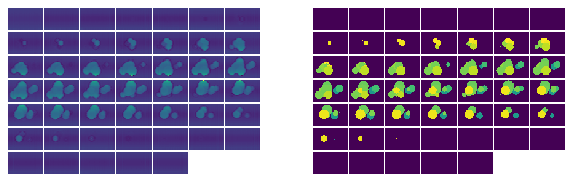

Dice:  tensor(0.9706)


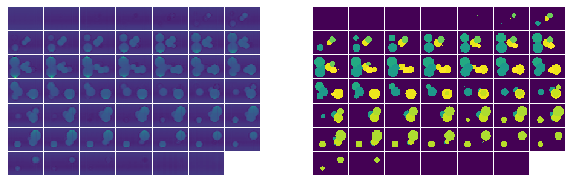

Dice:  tensor(0.9727)


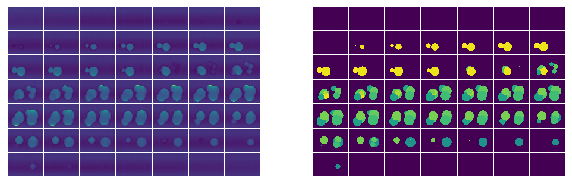

Avg Dice: 0.9738895297050476


In [10]:
val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-3:], segs[-3:])]
val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
data_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()
with torch.no_grad():
    for val_data in data_loader:
        val_images = val_data["img"].to(device)
        roi_size = (48, 48)
        sw_batch_size = 3
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            spatial_dim=1,  # Spatial dim to slice along is defined here
            device=torch.device("cpu"),
            padding_mode="replicate",
        )
        val_output = slice_inferer(val_images, model).cpu()
        dice_metric(y_pred=val_output > 0.5, y=val_data["seg"])
        print("Dice: ", dice_metric.get_buffer()[-1][0])
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        matshow3d(val_output[0], fig=plt.gca())
        plt.subplot(1, 2, 2)
        matshow3d(val_images[0], fig=plt.gca())
        plt.show()
    print(f"Avg Dice: {dice_metric.aggregate().item()}")

## Cleanup data directory

Remove directory if a temporary was used.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)